In [1]:
!git clone https://github.com/clinicalml/human_ai_deferral.git
%cd human_ai_deferral
!mkdir data
!pip install -r requirements.txt

Cloning into 'human_ai_deferral'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 191 (delta 46), reused 30 (delta 20), pack-reused 102 (from 1)
Receiving objects: 100% (191/191), 3.13 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [6]:
!pip install sentence-transformers gurobipy shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.8 MB/s eta 0:00:00


In [28]:
import torch
from helpers.metrics import *
from networks.linear_net import *
from networks.non_linear_net import *
import torch.optim as optim
#from datasetsdefer.hatespeech import *
from datasetsdefer.broward import *
from methods.realizable_surrogate import *
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam
scheduler = None
lr = 1e-2
total_epochs = 50
# generate data
#dataset = HateSpeech("data", True, False, 'random_annotator', device)
dataset = BrowardDataset("data")
model = LinearNet(dataset.d, 4).to(device)
#model = NonLinearNet(dataset.d, 4).to(device)
# instatiate method
RS = RealizableSurrogate(1, 300, model, device, True)
RS.fit_hyperparam(
    dataset.data_train_loader,
    dataset.data_val_loader,
    dataset.data_test_loader,
    epochs=total_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    lr=lr,
    verbose=False,
    test_interval=5,
)
rs_metrics = compute_deferral_metrics(RS.test(dataset.data_test_loader))

  0%|          | 0/50 [00:00<?, ?it/s]/content/human_ai_deferral/methods/realizable_surrogate.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  human_correct = torch.tensor(human_correct).to(self.device)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 12%|█▏        | 6/50 

In [29]:
import torch.nn.functional as F
import torch
import numpy as np

#for batch, (data_x, data_y, hum_preds) in enumerate(dataloader):
def predict(data_x):
  outputs = RS.model(torch.from_numpy(data_x))
  outputs_class = F.softmax(outputs[:, :-1], dim=1)
  outputs = F.softmax(outputs, dim=1)
  max_probs, predicted_class = torch.max(outputs.data[:, :-1], 1)
  defer_score = [ outputs.data[i][-1].item() - outputs.data[i][predicted_class[i]].item() for i in range(len(outputs.data))]
  return np.array(defer_score)


In [30]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

def train_surrogate_rejector(dataset):
  X_list,y_list =[],[]
  for data_x, data_y, human_y in dataset.data_train_loader:
    #concatenate all data_x
    X_list.append(data_x.numpy())

    #get model rejection values
    rej_score = predict(data_x.numpy())
    y_list.append(rej_score)
  X, y = np.vstack(X_list), np.vstack(y_list).flatten()
  surrogate_rejector = xgb.XGBRegressor().fit(X, y)
  #surrogate_rejector = DecisionTreeRegressor().fit(X, y)
  # EVALUATE PERFORMANCE ON VAL
  X_val, _, _ =next(iter(dataset.data_val_loader))
  y_val = predict(X_val.numpy())
  # Make predictions
  y_pred = surrogate_rejector.predict(X_val)
  # Training Loss
  mse = mean_squared_error(y_val, y_pred)
  print(f"Val MSE: {mse}")
  return surrogate_rejector

In [31]:
test_data = RS.test(dataset.data_test_loader)
error = -np.log(test_data["class_probs"][np.arange(len(test_data["labels"])), test_data["labels"]])
#train surrogate rejector
surrogate = train_surrogate_rejector(dataset)
X_test, _, _ =next(iter(dataset.data_test_loader))
# Surrogate deferal predictions
surr_pred = surrogate.predict(X_test)


Val MSE: 0.002855301452813938


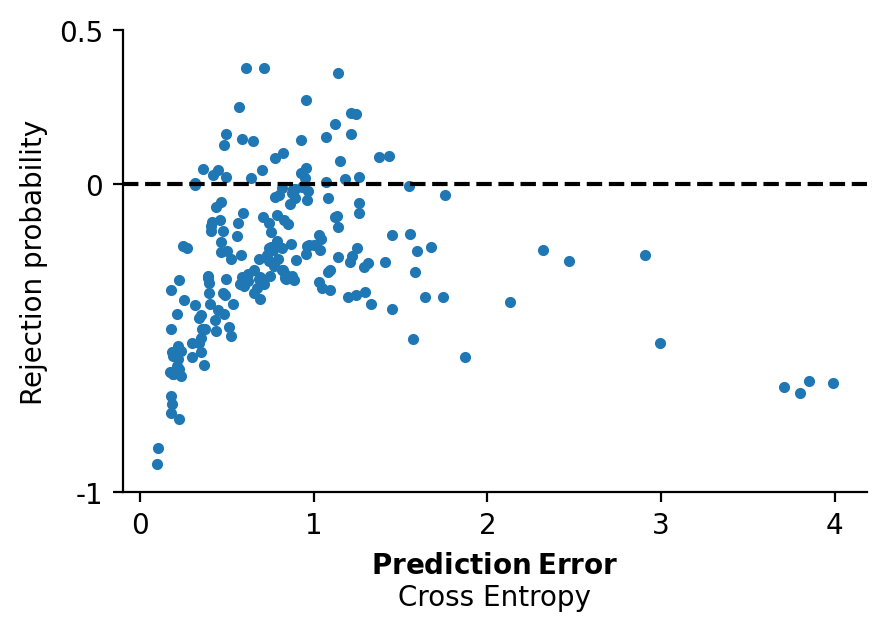

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.8,3),dpi=200)
ax.scatter(error,test_data["rej_score"],marker=".")
ax.axhline(0,linestyle="--", color="k")
ax.set_xlabel(r"$\bf{Prediction\:Error}$" + "\nCross Entropy")
ax.set_ylim(-1,0.5)
ax.set_yticks([-1,0,0.5],[-1,0,0.5])
ax.set_ylabel("Rejection probability")
ax.spines[['right', 'top']].set_visible(False)

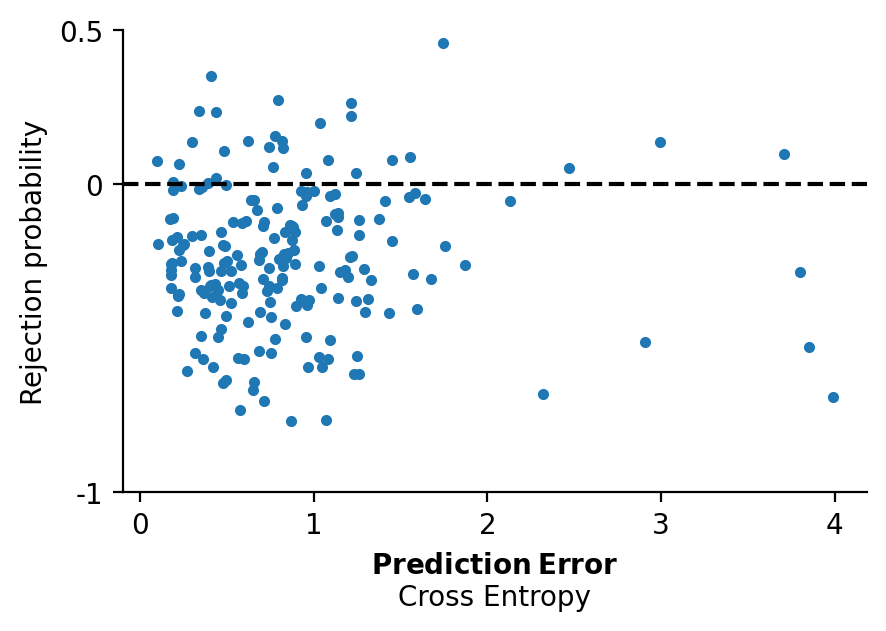

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.8,3),dpi=200)
ax.scatter(error,surr_pred,marker=".")
ax.axhline(0,linestyle="--", color="k")
ax.set_xlabel(r"$\bf{Prediction\:Error}$" + "\nCross Entropy")
ax.set_ylim(-1,0.5)
ax.set_yticks([-1,0,0.5],[-1,0,0.5])
ax.set_ylabel("Rejection probability")
ax.spines[['right', 'top']].set_visible(False)

In [34]:
import shap
data_x,data_y,human_pred = list(dataset.data_test_loader)[0]
#joint values
explainer = shap.KernelExplainer(predict, data_x.numpy())
shap_values = explainer.shap_values(data_x.numpy())

#surrogate_values
sur_explainer = shap.Explainer(surrogate)
sur_shap_values = sur_explainer(data_x.numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
 import pandas as pd
 broward_data = pd.read_csv(
                    "data/allDataBroward/BROWARD_CLEAN_SUBSET.csv"
                )

In [40]:
broward_data = broward_data.drop(["block_num", "id","two_year_recid"], axis=1)

In [41]:
data_x.numpy().shape

(200, 9)

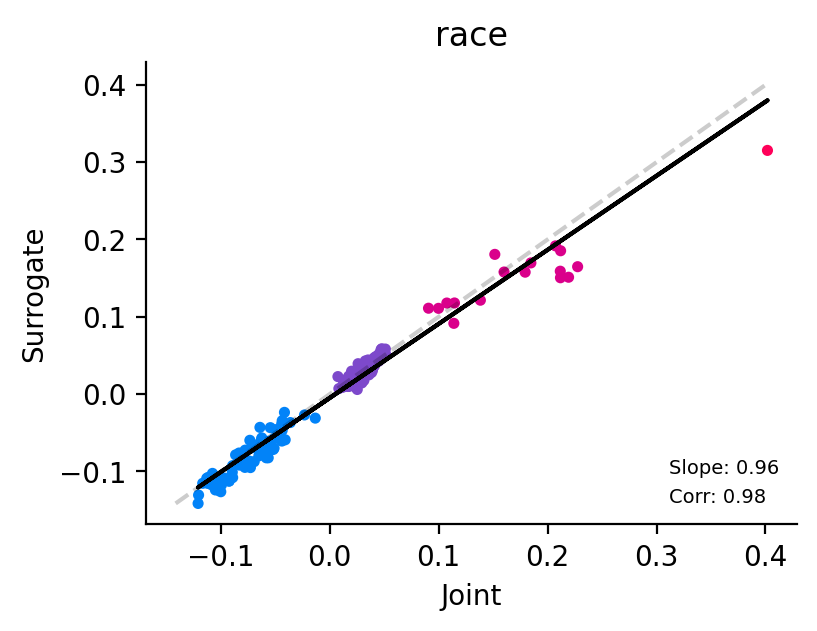

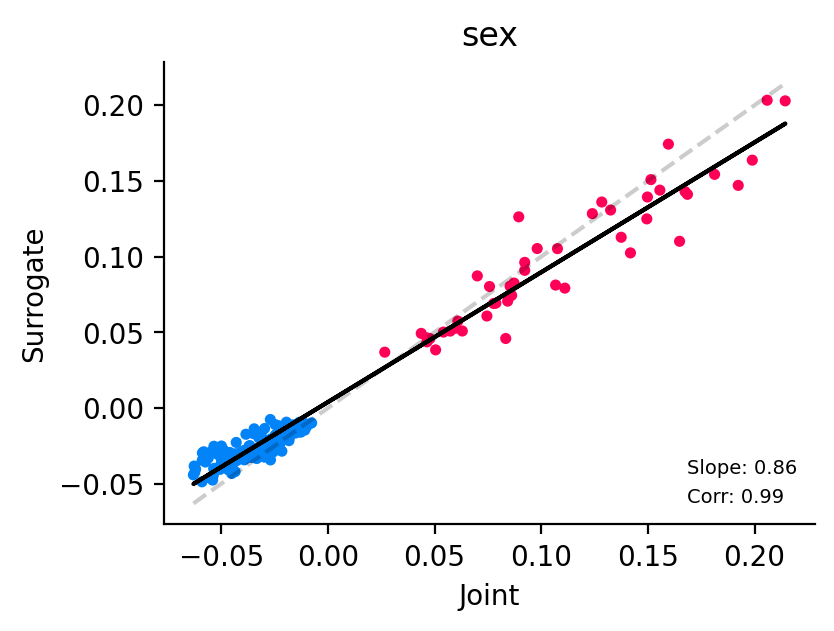

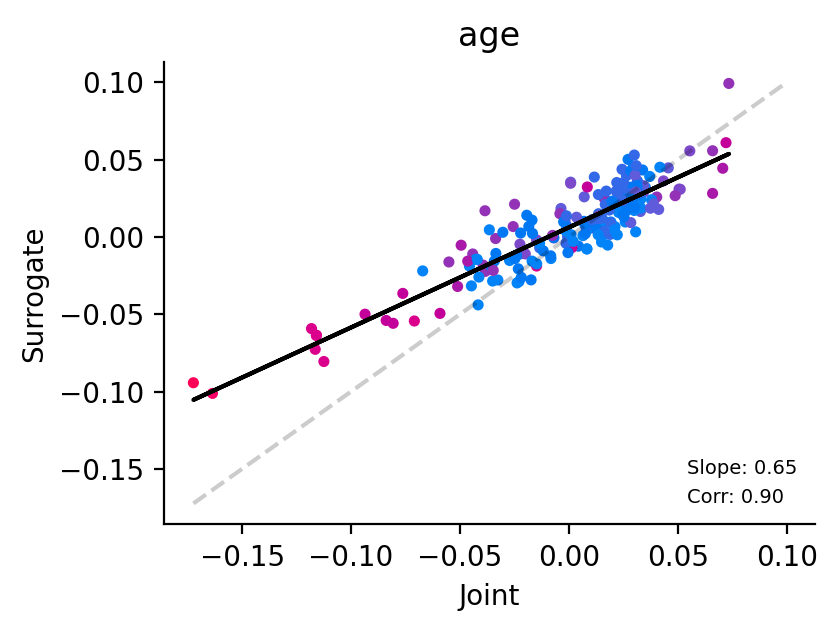

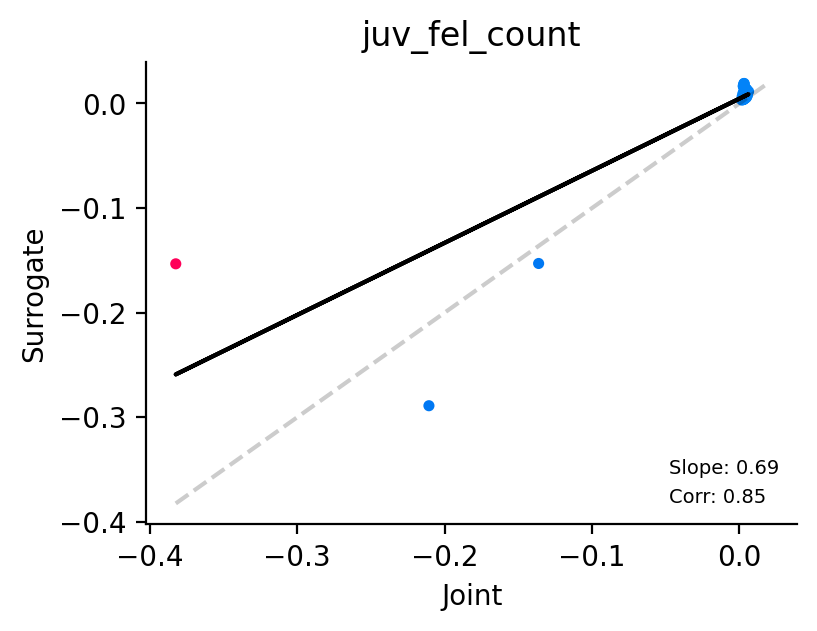

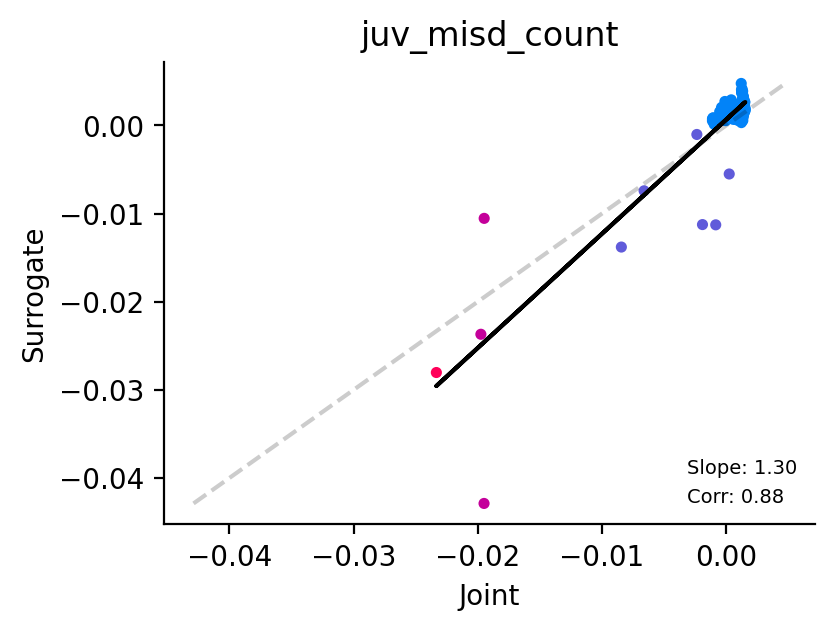

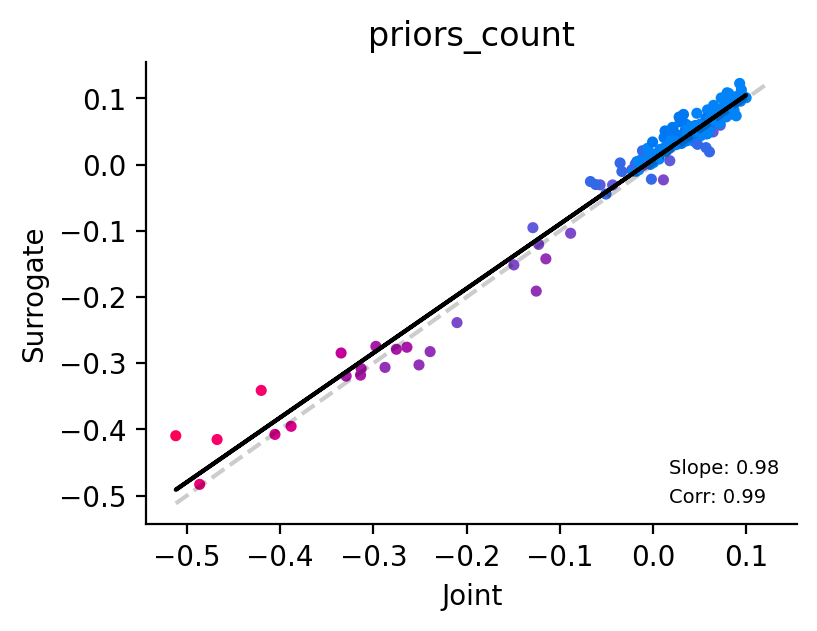

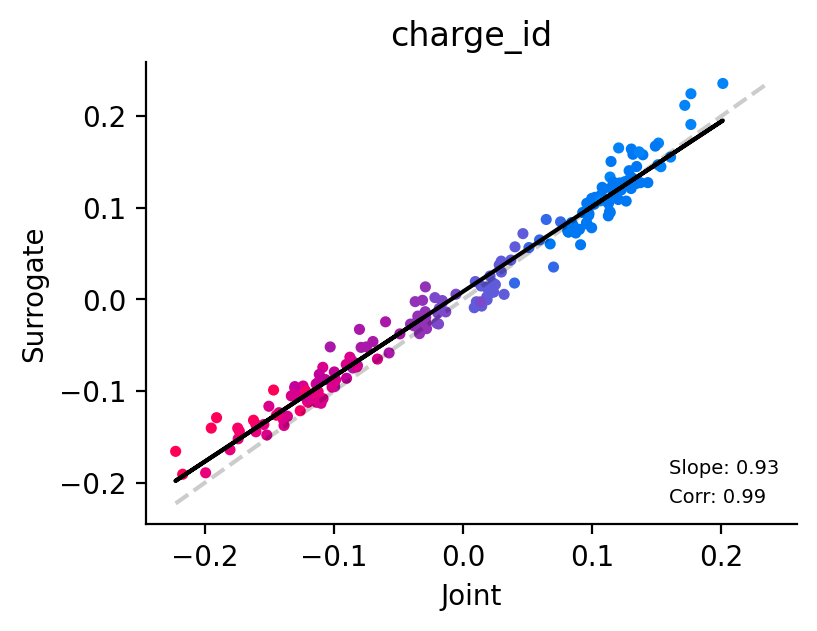

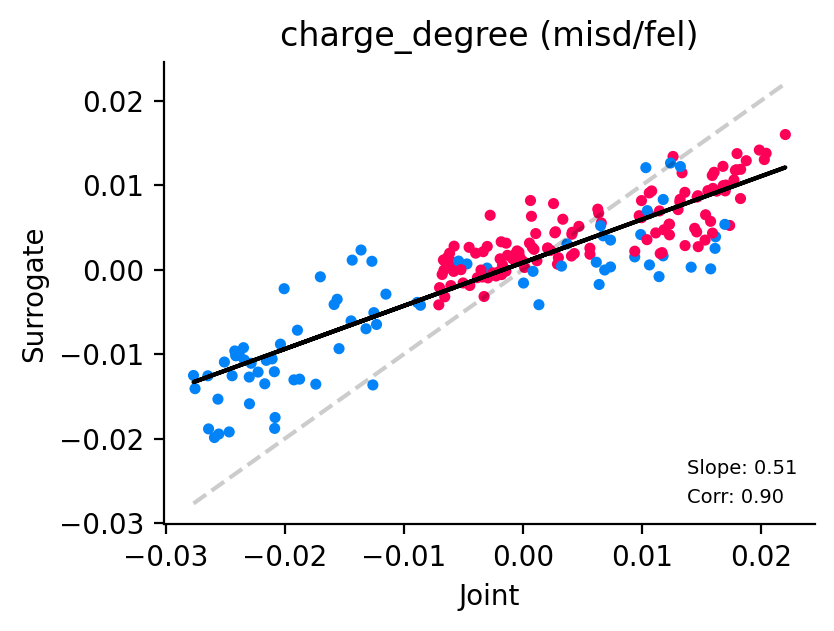

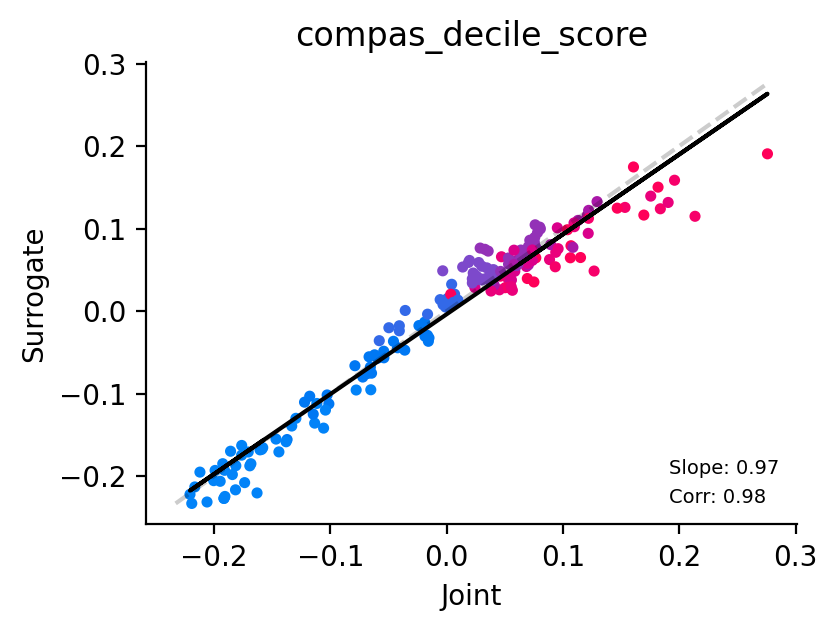

In [42]:
from scipy import stats
import matplotlib.colors as mcolors
# Create a custom colormap similar to SHAP's
colors = ['#0283F8', '#0078F3', '#3369E8', '#605BDA',"#7D49CB",
          "#9331B7","#A918A8","#C4009A","#DA008B","#EA007B",
          "#F7006A","#FF0059"]
n_bins = len(colors)
shap_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

for i, name in enumerate(broward_data.columns):
      x = shap_values[:, i]
      y = sur_shap_values.values[:, i]
      values = data_x[:,i]

      # Create the scatter plot
      fig, ax = plt.subplots(figsize=(4.2,3),dpi=200)
      ax.scatter(x, y,marker=".",c=values, cmap=shap_cmap)

      # Calculate and plot the linear regression line
      slope, intercept, r_value, _, _ = stats.linregress(x, y)
      line = slope * x + intercept
      ax.plot(x, line, color='k')

      # Plot x=y line
      min_val = min(x.min(), y.min())
      max_val = max(x.max(), y.max())
      ax.plot([min_val, max_val], [min_val, max_val], color='k', alpha=0.2, linestyle='--')

      # Calculate correlation coefficient
      correlation = np.corrcoef(x, y)[0, 1]

      # Set title, labels, and legend
      ax.set_title(f"{name}")
      ax.set_xlabel("Joint")
      ax.set_ylabel("Surrogate")
      ax.spines[['right', 'top']].set_visible(False)
      ax.plot([],[],color="white",label=f"Slope: {slope:.2f}")
      ax.plot([],[],color="white",label=f"Corr: {correlation:.2f}")
      plt.legend(fontsize=7,loc="lower right", frameon=False)
      plt.show()

In [ ]:
#for batch, (data_x, data_y, hum_preds) in enumerate(dataloader):
def predict_outputs(data_x):
  outputs = RS.model(torch.from_numpy(data_x))
  outputs_class = F.softmax(outputs[:, :-1], dim=1)
  outputs = F.softmax(outputs, dim=1)
  max_probs, predicted_class = torch.max(outputs.data[:, :-1], 1)
  return predicted_class

In [ ]:
preds = predict_outputs(data_x.numpy())

In [ ]:
preds

tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 0, 1, 1, 1, 1])

In [ ]:
import pandas as pd
hatespeech_data = pd.read_csv(
                    "data/hatespeech_labeled_data.csv"
                )

In [ ]:
import logging
import os
import pickle
import sys

import torch
import torch.optim as optim

sys.path.append("../")
import sys

import torch
import torch.nn as nn

sys.path.append("../")
import argparse
import datetime
# allow logging to print everything
import logging

from baselines.lce_surrogate import *
from datasetsdefer.synthetic_data import SyntheticData
from helpers.metrics import *
from networks.linear_net import *

logging.basicConfig(level=logging.DEBUG)
import datetime

import torch.optim as optim
from baselines.compare_confidence import *
from baselines.differentiable_triage import *
from baselines.lce_surrogate import *
from baselines.mix_of_exps import *
from baselines.one_v_all import *
from baselines.selective_prediction import *
from datasetsdefer.broward import *
from datasetsdefer.chestxray import *
from datasetsdefer.cifar_h import *
from datasetsdefer.cifar_synth import *
from datasetsdefer.generic_dataset import *
from datasetsdefer.hatespeech import *
from datasetsdefer.imagenet_16h import *
from datasetsdefer.synthetic_data import *
from methods.milpdefer import *
from methods.realizable_surrogate import *
from networks.cnn import *
from networks.cnn import DenseNet121_CE, NetSimple, WideResNet


def main():


    date_now = datetime.datetime.now()
    date_now = date_now.strftime("%Y-%m-%d_%H%M%S")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # {'classifier_all_acc': 0.9211, 'human_all_acc': 0.367, 'coverage': 0.9904, 'classifier_nondeferred_acc': 0.9262924071082391, 'human_deferred_acc': 0.3541666666666667, 'system_acc': 0.9208}

    data_dir = 'data'
    optimizer = optim.AdamW
    scheduler = None
    lr = 0.01
    max_trials = 10
    total_epochs = 500# 100
    errors_lce = []
    errors_rs = []
    errors_one_v_all = []
    errors_selective = []
    errors_compare_confidence = []
    errors_differentiable_triage = []
    errors_mixofexps = []

    # generate data
    dataset = BrowardDataset(data_dir, test_split = 0.2, val_split = 0.1)

    model = LinearNet(dataset.d,3).to(device)
    RS = RealizableSurrogate(1, 300, model, device, True)
    RS.fit_hyperparam(
        dataset.data_train_loader,
        dataset.data_val_loader,
        dataset.data_test_loader,
        epochs=total_epochs,
        optimizer=optimizer,
        scheduler=scheduler,
        lr=lr,
        verbose=False,
        test_interval=5,
    )
    rs_metrics = compute_coverage_v_acc_curve(RS.test(dataset.data_test_loader))

    model = LinearNet(dataset.d,3).to(device)
    LCE = LceSurrogate(1, 300, model, device)
    LCE.fit_hyperparam(
        dataset.data_train_loader,
        dataset.data_val_loader,
        dataset.data_test_loader,
        epochs=total_epochs,
        optimizer=optimizer,
        scheduler=scheduler,
        lr=lr,
        verbose=False,
        test_interval=5,
    )
    lce_metrics = compute_coverage_v_acc_curve(LCE.test(dataset.data_test_loader))

    model = LinearNet(dataset.d,3).to(device)
    OVA = OVASurrogate(1, 300, model, device)
    OVA.fit(
        dataset.data_train_loader,
        dataset.data_val_loader,
        dataset.data_test_loader,
        epochs=total_epochs,
        optimizer=optimizer,
        scheduler=scheduler,
        lr=lr,
        verbose=False,
        test_interval=5,
    )
    ova_metrics = compute_coverage_v_acc_curve(OVA.test(dataset.data_test_loader))

    model = LinearNet(dataset.d,2).to(device)
    SP = SelectivePrediction(model, device)
    SP.fit(
        dataset.data_train_loader,
        dataset.data_val_loader,
        dataset.data_test_loader,
        epochs=total_epochs,
        optimizer=optimizer,
        scheduler=scheduler,
        lr=lr,
        verbose=False,
        test_interval=5,
    )
    sp_metrics = compute_coverage_v_acc_curve(SP.test(dataset.data_test_loader))


main()


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 93%|█████████▎| 466/500 [00:32<00:02, 15.71it/s]/content/human_ai_deferral/methods/realizable_surrogate.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  human_correct = torch.tensor(human_correct).to(self.device)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi